In [52]:
%matplotlib inline

from HeaderP import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

def fitpoints(x,y):
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    return p


from tqdm import trange
import math
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        
        x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
        y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux
        
        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

def calcmidval(x_med,y_med,x_val):
    sort_x_med,sort_y_med=zip(*sorted(zip(x_med,y_med)))
    sort_x_med=np.asarray(sort_x_med)
    sort_y_med=np.asarray(sort_y_med)
    if x_val in sort_x_med:
        m=(sort_x_med==x_val)
        #print(sort_y_med[m])
        return sort_y_med[m][0]
    else:
        for i in range(len(sort_x_med)):
            if sort_x_med[i]>x_val:
                if i==0:
                    return sort_y_med[0]
                else:
                    p=fitpoints([sort_x_med[i-1],sort_x_med[i]],[sort_y_med[i-1],sort_y_med[i]])
                    return p(x_val)
            return(sort_y_med[-1])
        
def calc_measure_disp(df,name,method='movingmedian',p=0):
    trytime=100
    agedisp=[]
    
    x,xerr=df['Age'].values,df['Age_err'].values
    y,yerr=df[name].values,df[name+'_ERR'].values
    
    if method=='movingmedian':
        for i in range(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            df['newmed']=np.array([calcmidval(df['med_age'],df['med_abun'],i) for i in df['newage']])
        
            agedisp.append(np.mean((df[name]-df['newmed'])**2.))
            
    elif method=='linear':
        for i in range(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            df['newmed']=p(df['newage'])
            
            agedisp.append(np.mean((df[name]-df['newmed'])**2.))
            
    
            
    return np.std(np.array(agedisp))**2.+(np.mean(yerr)*1.2)**2.


def calc_disp(df,name,method='movingmedian',p=0):
    df_dropna=df.dropna(subset=['med_age',name,'med_abun',name+'_ERR'])

    if method=='movingmedian':
        # calcualte total dispersion
        totdisp=np.mean((df_dropna[name]-df_dropna['med_abun'])**2.)
        #print(totdisp)
    
        # calculate measurement dispersion
        meadisp=calc_measure_disp(df,name)
        
    elif method=='linear':
        # calcualte total dispersion
        totdisp=np.mean((df_dropna[name]-p(df_dropna['Age']))**2.)
        meadisp=calc_measure_disp(df,name,'linear',p)
        
    
    #print(df['Age_err'])
    # calculate int dispersion
    intdisp=np.sqrt(totdisp-meadisp)
    print('total',totdisp,'measured',meadisp,'intr',intdisp)
    return np.sqrt(totdisp),intdisp


from scipy.ndimage import gaussian_filter
def plotTrends(df_abun_st_ha,df_abun_st_la,figname,method='movingmedian',order=1):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    abundlim={'C_FE':[-0.25,0.25],'MG_FE':[-0.25,0.25],'AL_FE':[-0.25,0.25],'SI_FE':[-0.25,0.25],
              'S_FE':[-0.25,0.25],'CA_FE':[-0.1,0.1],'TI_FE':[-0.25,0.25],'CR_FE':[-0.1,0.1],
              'MN_FE':[-0.25,0.25],'CO_FE':[-0.25,0.25],'NI_FE':[-0.1,0.1],'CU_FE':[-0.25,0.25],
              'O_FE':[-0.25,0.25],'NA_FE':[-0.25,0.25],'K_FE':[-0.25,0.25],'V_FE':[-0.25,0.25],
              'P_FE':[-0.25,0.25],'RB_FE':[-0.25,0.25],'N_FE':[-0.5,0.5],'M_H':[-0.1,0.1]}


    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #

    Abunname=[]
    hi_dis=[]
    lo_dis=[]

    tot_hi_dis=[]
    tot_lo_dis=[]

    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        #clear_output(wait = True)
        
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']<10]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_la=df_plot_la.loc[df_plot_la['Age']<10]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        #print('errer',df_plot_ha['Age_err'])
    
        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
        #print(df_plot_ha['Age_err'])
    
        if method=='movingmedian':
            df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la[abun_apog[i]].values,
                                                                agewindow,slidwindow)
            df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha[abun_apog[i]].values,
                                                                agewindow,slidwindow)
    
            df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
            df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
            df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
            df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
        elif method=='linear':
            if len(df_plot_la)==0 or len(df_plot_ha)==0:
                continue
            z = np.polyfit(df_plot_la['Age'].values,df_plot_la[abun_apog[i]].values,order)
            p_la = np.poly1d(z)
            z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha[abun_apog[i]].values,order)
            p_ha = np.poly1d(z)
            
            
            df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
            df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
            df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
            df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]],fmt='b.',alpha=0.2,label='low-$\\alpha$')
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
        if len(df_plot_la['Age'])!=0:   
            print(abun_apog[i])
        
            plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
            plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')
        
            #print(df_plot_ha['Age_err'])
            if method=='movingmedian':
                tot_la,disp_la=calc_disp(df_plot_la,abun_apog[i])
                tot_ha,disp_ha=calc_disp(df_plot_ha,abun_apog[i])
            elif method=='linear':
                tot_la,disp_la=calc_disp(df_plot_la,abun_apog[i],'linear',p_la)
                tot_ha,disp_ha=calc_disp(df_plot_ha,abun_apog[i],'linear',p_ha)
                
            #print(abun_apog[i])
            plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)
    
    
            Abunname.append(abund[abun_apog[i]]+'Fe]')
            hi_dis.append(disp_ha)
            lo_dis.append(disp_la)
            tot_hi_dis.append(tot_ha)
            tot_lo_dis.append(tot_la)
        
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        plt.ylim(abundlim[abun_apog[i]])
    
    
    
    #plt.legend()
    
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
    if method=='movingmedian':
        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['M_H'].values,
                                                                agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['M_H'].values,
                                                                agewindow,slidwindow)
    
        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    elif method=='linear':
        z = np.polyfit(df_plot_la['Age'].values,df_plot_la['M_H'].values,order)
        p_la = np.poly1d(z)
        z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha['M_H'].values,order)
        p_ha = np.poly1d(z)
            
            
        df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
        df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],fmt='b.',alpha=0.2,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
    plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
    plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')

    if method=='movingmedian':
            tot_la,disp_la=calc_disp(df_plot_la,'M_H')
            tot_ha,disp_ha=calc_disp(df_plot_ha,'M_H')
    elif method=='linear':
            tot_la,disp_la=calc_disp(df_plot_la,'M_H','linear',p_la)
            tot_ha,disp_ha=calc_disp(df_plot_ha,'M_H','linear',p_ha)
            
    plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)

    Abunname.append('Fe')
    hi_dis.append(disp_ha)
    lo_dis.append(disp_la)
    tot_hi_dis.append(tot_ha)
    tot_lo_dis.append(tot_la)

    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.ylim([-0.1,0.1])
    #plt.legend()
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha['C_N']=df_plot_ha['C_FE']-df_plot_ha['N_FE']
    df_plot_ha['C_N_ERR']=np.sqrt(df_plot_ha['C_FE_ERR']**2.+df_plot_ha['N_FE_ERR']**2.)
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la['C_N']=df_plot_la['C_FE']-df_plot_la['N_FE']
    df_plot_la['C_N_ERR']=np.sqrt(df_plot_la['C_FE_ERR']**2.+df_plot_la['N_FE_ERR']**2.)
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])    
    
    if method=='movingmedian':
        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['C_N'].values,
                                                                agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['C_N'].values,
                                                                agewindow,slidwindow)
    
        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    elif method=='linear':
        z = np.polyfit(df_plot_la['Age'].values,df_plot_la['C_N'].values,order)
        p_la = np.poly1d(z)
        z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha['C_N'].values,order)
        p_ha = np.poly1d(z)
            
            
        df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
        df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_N'],fmt='b.',alpha=0.2,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_N'],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
    plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
    plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')

    if method=='movingmedian':
            tot_la,disp_la=calc_disp(df_plot_la,'C_N')
            tot_ha,disp_ha=calc_disp(df_plot_ha,'C_N')
    elif method=='linear':
            tot_la,disp_la=calc_disp(df_plot_la,'C_N','linear',p_la)
            tot_ha,disp_ha=calc_disp(df_plot_ha,'C_N','linear',p_ha)
  
    Abunname.append('[C/N]')
    hi_dis.append(disp_ha)
    lo_dis.append(disp_la)
    tot_hi_dis.append(tot_ha)
    tot_lo_dis.append(tot_la)

    plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)

    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.ylim([-0.5,0.5])
    #plt.legend()

    plt.tight_layout()

    plt.savefig(figname+'.png')
    return hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname

def tempcheck(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}

    plt.figure(figsize=(22.5,25))
    cm = plt.cm.get_cmap('viridis',5)
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
    
        plt.subplot(5,4,i+1)
        plt.scatter(df_plot_la['Age'],df_plot_la[abun_apog[i]],c=df_plot_la['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff)
        plt.scatter(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],c=df_plot_ha['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff)
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.scatter(df_plot_la['Age'],df_plot_la['M_H'],c=df_plot_la['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,
            alpha=0.5,label='low-$\\alpha$')
    plt.scatter(df_plot_ha['Age'],df_plot_ha['M_H'],c=df_plot_ha['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,
            alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.scatter(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             c=df_plot_la['TEFF'],alpha=0.5,vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,label='low-$\\alpha$')
    plt.scatter(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],
             c=df_plot_ha['TEFF'],alpha=0.5,vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,label='high-$\\alpha$')
    
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()


    plt.tight_layout()


    
def plotraw(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    lim=[-0.5,0.5]
    limx=[0,15]
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]],yerr=df_plot_la[abun_apog[i]+'_ERR'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],yerr=df_plot_ha[abun_apog[i]+'_ERR'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        plt.ylim(lim)
        plt.xlim(limx)
        plt.legend()
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],
             fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)


    plt.tight_layout()
    

def plotagedis(df_abun_st_ha,df_abun_st_la,agebin,start,end):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    size=int(np.ceil((end-start)/agebin))
    age_binned=[(2*j+1)*agebin/2+start for j in range(size)]

    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        clear_output(wait = True)
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']<10]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
        df_plot_ha=df_plot_ha.reset_index(drop=True)

        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.loc[df_plot_la['Age']<10]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
        df_plot_la=df_plot_la.reset_index(drop=True)


        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])



        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                    df_plot_la[abun_apog[i]].values,
                                                                    agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                    df_plot_ha[abun_apog[i]].values,
                                                                    agewindow,slidwindow)

        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)


        plt.subplot(5,4,i+1)


        if len(df_plot_la['Age'])!=0:   
            print(abun_apog[i])

            dispersions_la=[]
            dispersions_ha=[]
            dispersions_la_err=[]
            dispersions_ha_err=[]
            for j in range(size):
                agemin=j*agebin+start
                agemax=(j+1)*agebin+start

                new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
                new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

                new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
                new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


                tot_la,disp_la=calc_disp(new_df_inbin_la,abun_apog[i])
                tot_ha,disp_ha=calc_disp(new_df_inbin_ha,abun_apog[i])

                dispersions_la.append(disp_la)
                dispersions_ha.append(disp_ha)
                
                if len(new_df_inbin_la)==0:
                    range_la=0
                else:
                    range_la=max(new_df_inbin_la[abun_apog[i]])-min(new_df_inbin_la[abun_apog[i]])
                if len(new_df_inbin_ha)==0:
                    range_ha=0
                else:
                    range_ha=max(new_df_inbin_ha[abun_apog[i]])-min(new_df_inbin_ha[abun_apog[i]])
                
                dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
                dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))

            plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
            plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

        plt.ylabel(abund[abun_apog[i]]+'Fe] dispersion')
        plt.xlabel('Age bin center [Gyr]')



        #plt.legend()

    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)

    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])

    df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['M_H'].values,
                                                                agewindow,slidwindow)
    df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['M_H'].values,
                                                                agewindow,slidwindow)

    df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
    df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

    plt.subplot(5,4,1)
    dispersions_la=[]
    dispersions_ha=[]
    dispersions_la_err=[]
    dispersions_ha_err=[]
    clear_output(wait = True)
    print('FE_H')
    for j in range(size):
        agemin=j*agebin+start
        agemax=(j+1)*agebin+start

        new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
        new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

        new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
        new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


        tot_la,disp_la=calc_disp(new_df_inbin_la,'M_H')
        tot_ha,disp_ha=calc_disp(new_df_inbin_ha,'M_H')

        if len(new_df_inbin_la)==0:
            range_la=0
        else:
            range_la=max(new_df_inbin_la['M_H'])-min(new_df_inbin_la['M_H'])
        if len(new_df_inbin_ha)==0:
            range_ha=0
        else:
            range_ha=max(new_df_inbin_ha['M_H'])-min(new_df_inbin_ha['M_H'])
                    
        dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
        dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))
 
        dispersions_la.append(disp_la)
        dispersions_ha.append(disp_ha)

    plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
    plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

    plt.ylabel('Fe dispersion')
    plt.xlabel('Age bin center [Gyr]')
    #plt.legend()

    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha['C_N']=df_plot_ha['C_FE']-df_plot_ha['N_FE']
    df_plot_ha['C_N_ERR']=np.sqrt(df_plot_ha['C_FE_ERR']**2.+df_plot_ha['N_FE_ERR']**2.)
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)

    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la['C_N']=df_plot_la['C_FE']-df_plot_la['N_FE']
    df_plot_la['C_N_ERR']=np.sqrt(df_plot_la['C_FE_ERR']**2.+df_plot_la['N_FE_ERR']**2.)
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])    

    df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['C_N'].values,
                                                                agewindow,slidwindow)
    df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['C_N'].values,
                                                                agewindow,slidwindow)

    df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
    df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

    plt.subplot(5,4,20)
    dispersions_la=[]
    dispersions_ha=[]
    dispersions_la_err=[]
    dispersions_ha_err=[]
    clear_output(wait = True)
    print('C_N')
    for j in trange(size):
        agemin=j*agebin+start
        agemax=(j+1)*agebin+start

        new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
        new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

        new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
        new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


        tot_la,disp_la=calc_disp(new_df_inbin_la,'C_N')
        tot_ha,disp_ha=calc_disp(new_df_inbin_ha,'C_N')

        if len(new_df_inbin_la)==0:
            range_la=0
        else:
            range_la=max(new_df_inbin_la['C_N'])-min(new_df_inbin_la['C_N'])
        if len(new_df_inbin_ha)==0:
            range_ha=0
        else:
            range_ha=max(new_df_inbin_ha['C_N'])-min(new_df_inbin_ha['C_N'])
            
        dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
        dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))
        
        dispersions_la.append(disp_la)
        dispersions_ha.append(disp_ha)

    plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
    plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

    plt.ylabel('[C/N] dispersion')
    plt.xlabel('Age bin center [Gyr]')
    #plt.legend()

    plt.tight_layout()

# For sesmic stars

## Get high/low-$\alpha$ disk

Ages from https://ui.adsabs.harvard.edu/abs/2019yCat..22390032P/abstract

In [13]:
hdulist = fits.open('asu.fit')


In [14]:
df1 = pd.DataFrame(hdulist[1].data, dtype="float64")
df2 = pd.DataFrame(hdulist[2].data, dtype="float64")

In [15]:
df=pd.merge(df1,df2,left_on='KIC',right_on='KIC',how='inner')

In [16]:
df_apo=pd.read_pickle('/Users/lucy/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')
df_apo['2MASS']=[i[2:] for i in df_apo['APOGEE_ID']]
df=pd.merge(df,df_apo,left_on='_2MASS',right_on='2MASS',how='inner')

In [17]:
def convd2R(x):
    return x/180*np.pi

df['X'] = df.GAIA_R_EST * np.cos(convd2R(df.GLAT)) * np.cos(convd2R(df.GLON)) / 1000.
df['Y'] = -df.GAIA_R_EST * np.sin(convd2R(df.GLON)) * np.cos(convd2R(df.GLAT))/ 1000.
df['z'] = df.GAIA_R_EST * np.sin(convd2R(df.GLAT))/ 1000.
df['R'] = np.sqrt(np.power(df.X - 8.2,2.) + np.power(df.Y,2.))


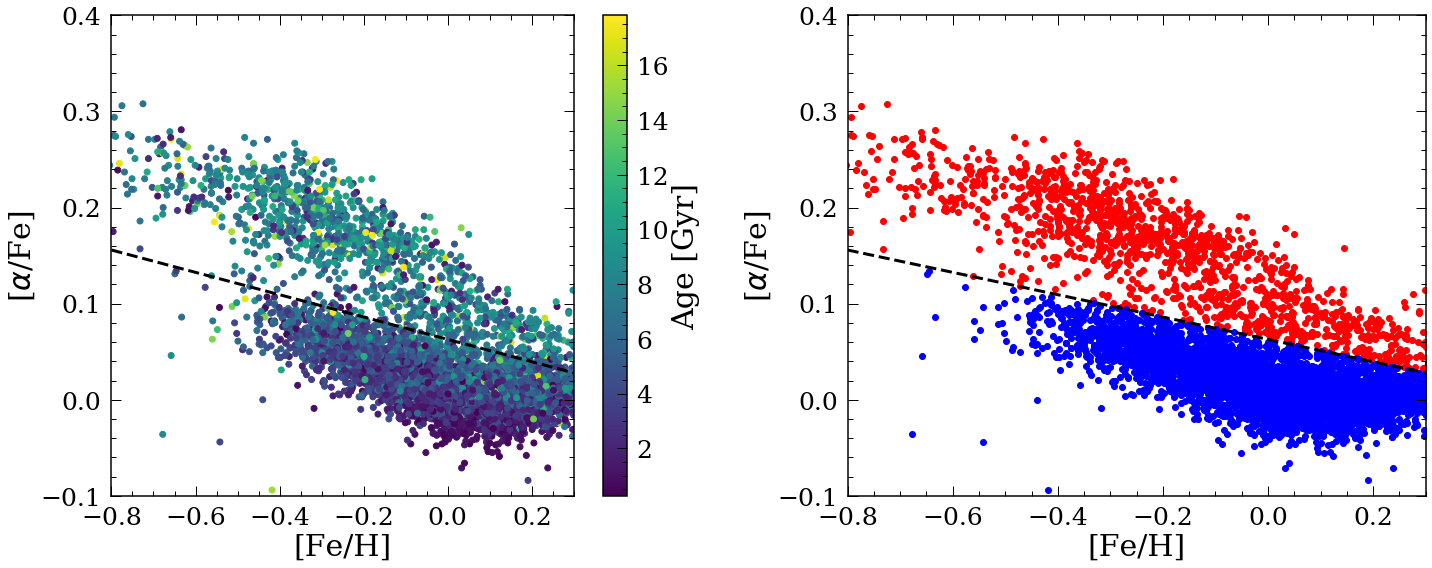

In [18]:
df['Age']=np.power(10,df['LogAge'])/1e3
df['Age_err']=np.power(10,df['E_LogAge'])/1e3

p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['FeH'],df['AFe'],c=df['Age'])
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')


high_alpha=df[df['AFe']-p(df['FeH'])>=0]
low_alpha=df[df['AFe']-p(df['FeH'])<0]

p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.subplot(1,2,2)
plt.scatter(high_alpha['FeH'],high_alpha['AFe'],c='r')
plt.scatter(low_alpha['FeH'],low_alpha['AFe'],c='b')
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()

In [19]:
#df.to_pickle('ASstars.pkl')

In [20]:
df_abun_st_ha=high_alpha.loc[abs(high_alpha['FeH'])<0.1]
#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['GAIA_R_EST']-2000)<1000]

df_abun_st_la=low_alpha.loc[abs(low_alpha['FeH'])<0.1]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['GAIA_R_EST']-2000)<1000]


4585.221139827245 8.033656927837477 0.4609158481223347


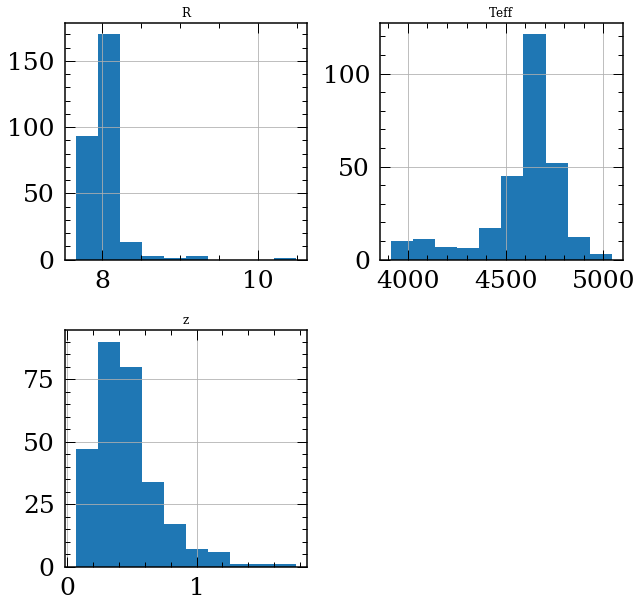

In [21]:
df_abun_st_ha[['R','z','Teff']].hist()
print(np.mean(df_abun_st_ha['Teff']),np.mean(df_abun_st_ha['R']),np.mean(df_abun_st_ha['z']))


## Select temperature range and plot individual element abundance trend

In [22]:
rangeTeff=25
tempcut=4674

rangeR=0.25
Rcut=7.98

rangez=0.5
zcut=0.46

print(len(df_abun_st_ha))
df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['Teff']-tempcut)<rangeTeff]
df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['Teff']-tempcut)<rangeTeff]
print(len(df_abun_st_ha))

#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['R']-Rcut)<rangeR]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['R']-Rcut)<rangeR]
#print(len(df_abun_st_ha))

#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['z']-zcut)<rangez]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['z']-zcut)<rangez]

print(len(df_abun_st_ha))

284
41
41


C_FE
total 0.0016511378596154244 measured 0.00010868003246327595 intr 0.039274136873420254
total 0.0017875161852368134 measured 0.00010917614533943004 intr 0.04096754861957673
N_FE
total 0.002651281052927566 measured 0.0002673027410130479 intr 0.04882600036778067
total 0.0012772719264304603 measured 0.00026992402385857945 intr 0.0317387445021362
O_FE
total 0.00068533020080131 measured 0.00016851345477417873 intr 0.022733603894392357
total 0.00112731321780805 measured 0.00016526565184343236 intr 0.031016891623188447
NA_FE
total 0.016168711969988776 measured 0.0015882588699920822 intr 0.12074954699706618
total 0.033455493287611764 measured 0.0015899084393731938 intr 0.17850934106717936
MG_FE
total 0.0008962047241016328 measured 0.00012061504886979039 intr 0.0278494106801534
total 0.0015820200452169282 measured 0.00011913834306345487 intr 0.03824763655643932
AL_FE
total 0.0012941006396752826 measured 0.000381753323324668 intr 0.030205087590513865
total 0.003986533023901194 measured 0.0003

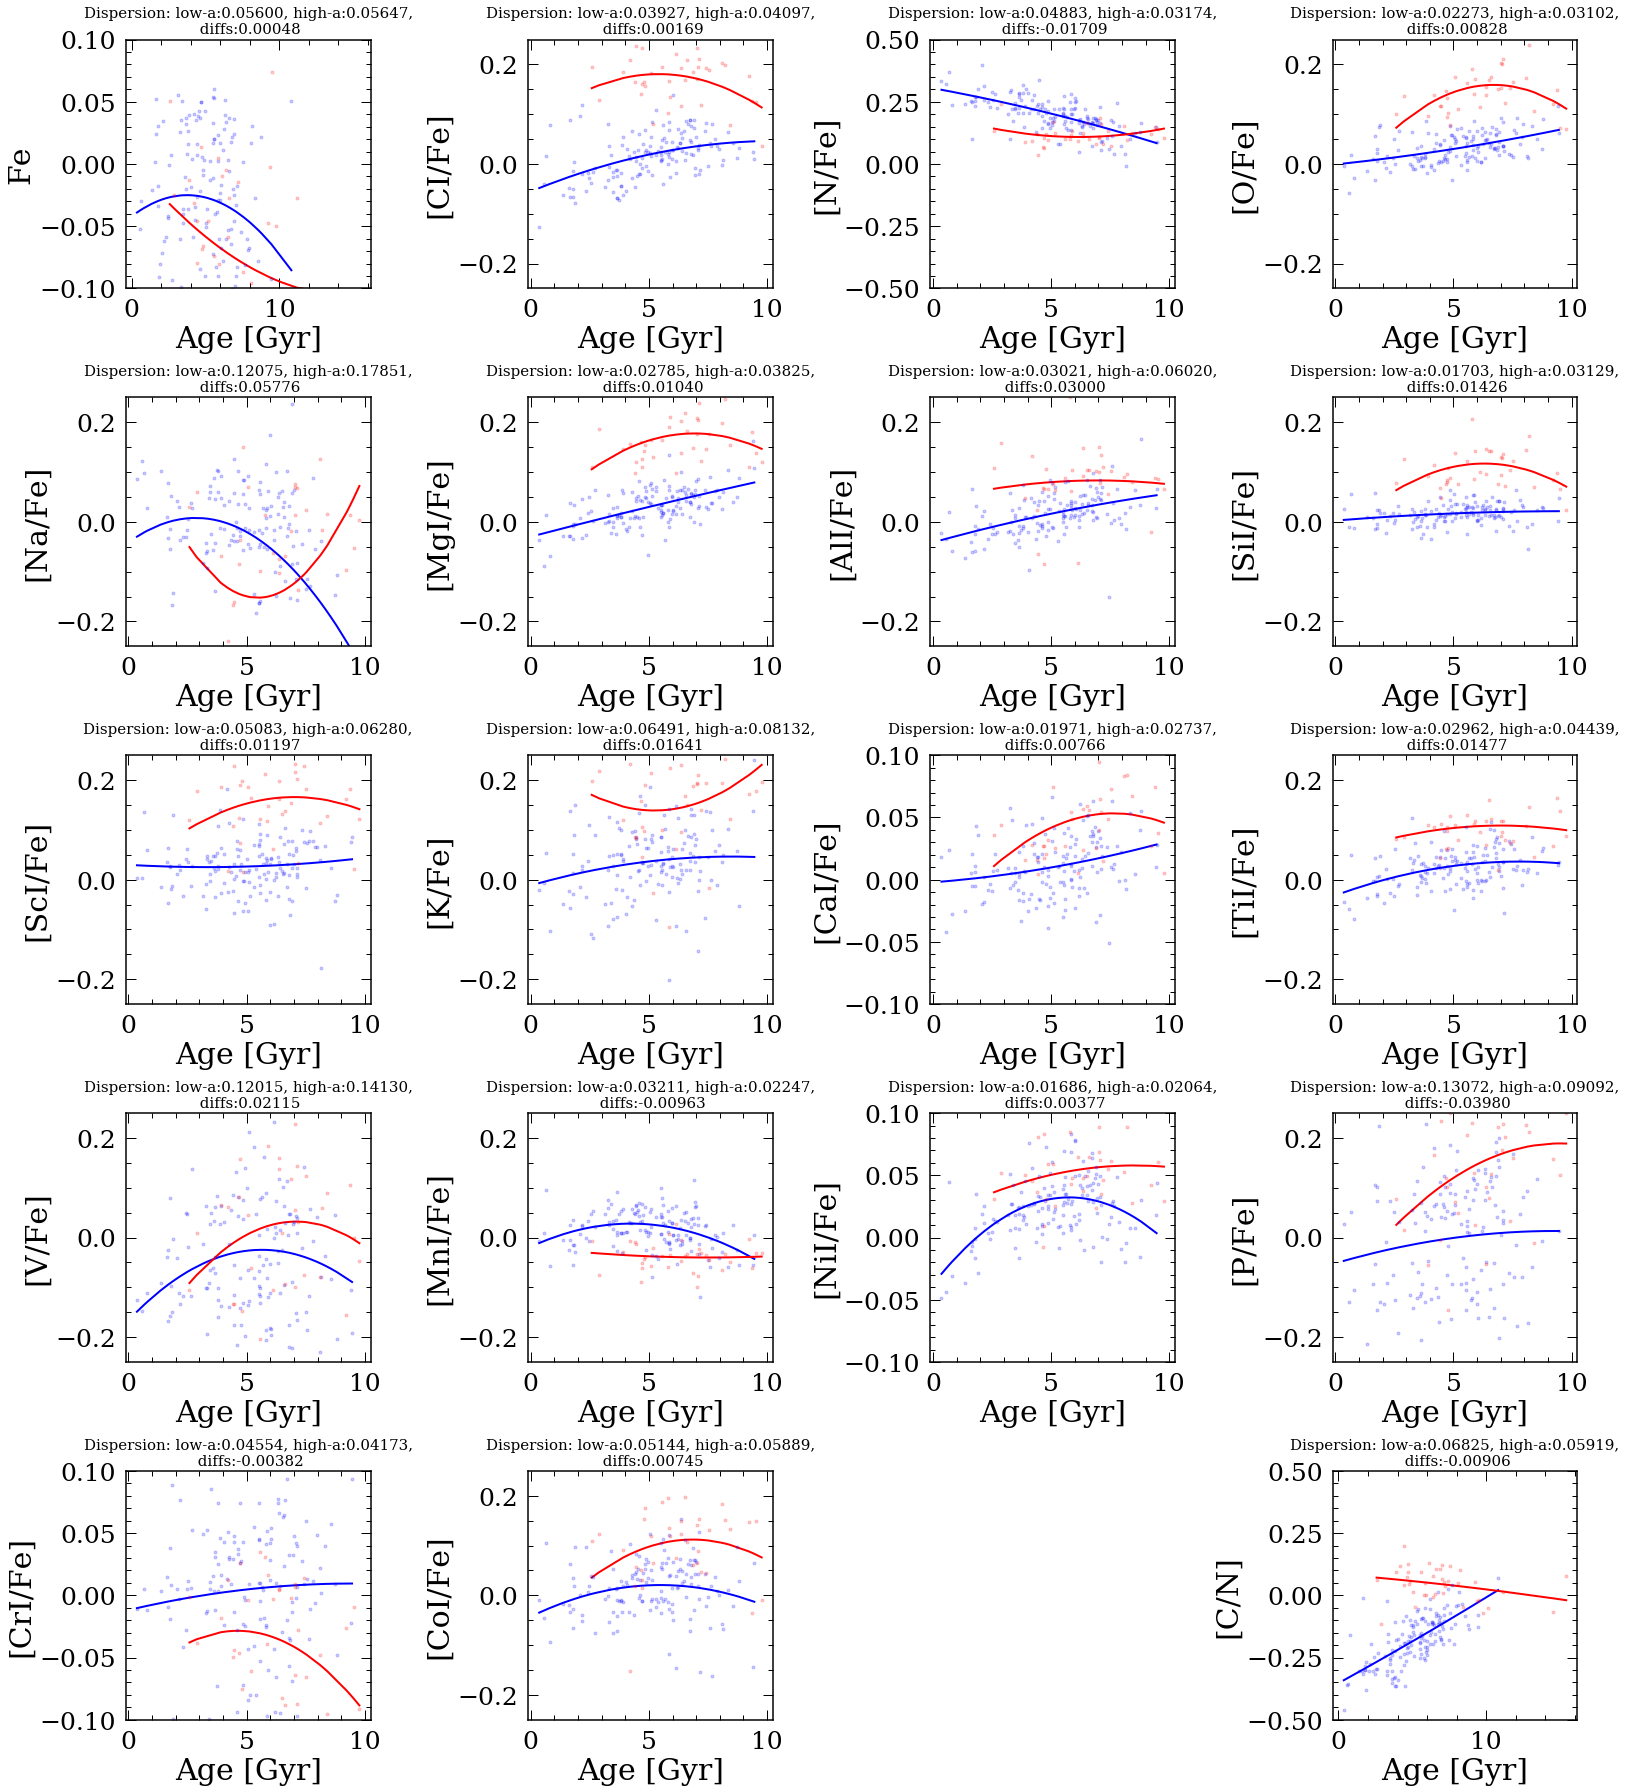

In [43]:
hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance','linear',2)


In [44]:
Abunname=[i.split('/')[0].split('[')[-1] for i in Abunname]
df_disp=pd.DataFrame(np.array((Abunname,lo_dis,hi_dis)).T,columns=['Abund','la_dis_astro','ha_dis_astro'])
lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis=zip(*sorted(zip(lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis)))
df_disp

,Abund,la_dis_astro,ha_dis_astro
0,CI,0.039274136873420254,0.04096754861957673
1,N,0.04882600036778067,0.0317387445021362
2,O,0.022733603894392357,0.031016891623188447
3,Na,0.12074954699706618,0.17850934106717936
4,MgI,0.0278494106801534,0.03824763655643932
5,AlI,0.030205087590513865,0.06020472794264863
6,SiI,0.01703201219931992,0.031293670550095784
7,ScI,0.05082851858687079,0.06279880111837992
8,K,0.06491447718801607,0.08132051383654049
9,CaI,0.01970975351652767,0.027366369269866297


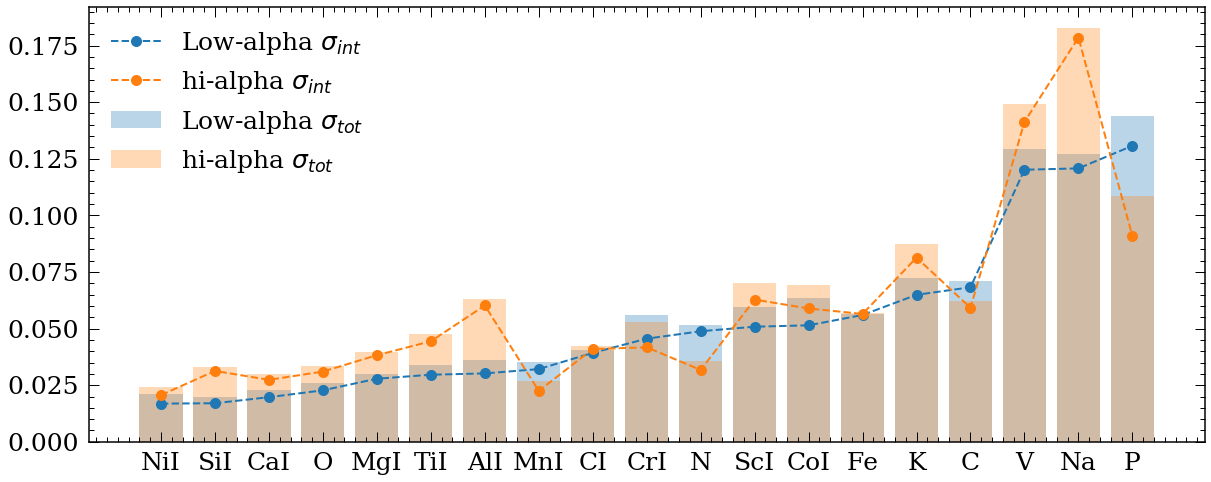

In [45]:
# normal error
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_astro.png')

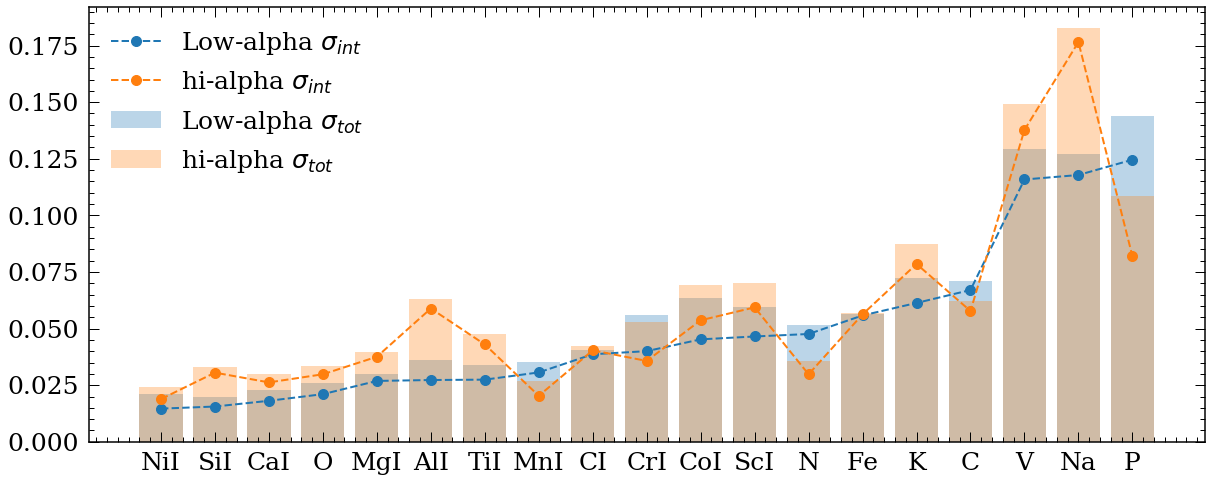

In [41]:
# 1.2*error
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_astro.png')

In [46]:
df_CM=pd.read_pickle('CannonDR16.pkl')
print('before cutting:',len(df_CM))
# After cutting
#df=df.loc[abs(df['[Mg/Fe]']-df['MG_FE'])<0.2]
#df=df.loc[df['TEFF']<5200]
#print('after cutting:',len(df))

# get red clump stars
df=df_CM.loc[df_CM['DP']>230]




before cutting: 116301


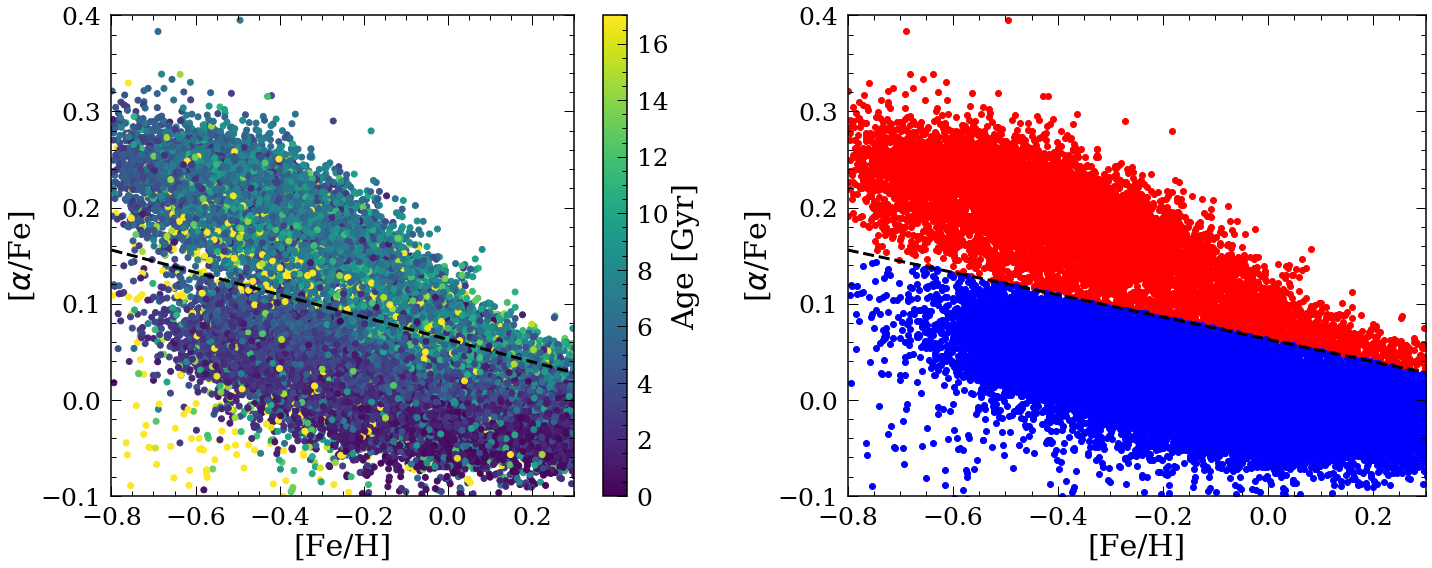

In [47]:
p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['M_H'],df['ALPHA_M'],c=df['Age'],vmin=0,vmax=17)
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')


high_alpha=df[df['ALPHA_M']-p(df['M_H'])>=0]
low_alpha=df[df['ALPHA_M']-p(df['M_H'])<0]

p=fitpoints([-0.75,0.11],[0.15,0.05])

plt.subplot(1,2,2)
plt.scatter(high_alpha['M_H'],high_alpha['ALPHA_M'],c='r')
plt.scatter(low_alpha['M_H'],low_alpha['ALPHA_M'],c='b')
plt.plot([-0.8,0.3],p([-0.8,0.3]),'k--',linewidth=3)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()

In [48]:
df_abun_st_ha=high_alpha.loc[abs(high_alpha['M_H'])<0.1]
#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['GAIA_R_EST']-2000)<1000]

df_abun_st_la=low_alpha.loc[abs(low_alpha['M_H'])<0.1]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['GAIA_R_EST']-2000)<1000]




C_FE
total 0.00433105271336499 measured 0.00023706577994487914 intr 0.06398427098451705
total 0.0020319122116053993 measured 0.000192999359769375 intr 0.04288254717056841
N_FE
total 0.005100781228838994 measured 0.0005508398636764185 intr 0.06745325318442821
total 0.003195840461127163 measured 0.00045888017447384065 intr 0.05231596588665187
O_FE
total 0.0018285633419521505 measured 0.0003594195223716697 intr 0.03832941193888162
total 0.0013696881935784326 measured 0.0003065755426391097 intr 0.032605408308121565
NA_FE
total 0.02516395740753139 measured 0.002814573342335061 intr 0.1494971038689256
total 0.030545489907573636 measured 0.0027951237817296602 intr 0.16658441141308503
MG_FE
total 0.0013297731923124063 measured 0.00020484623196195034 intr 0.033539930834014194
total 0.0019044586160783393 measured 0.00021629913143599526 intr 0.041087218020235246
AL_FE
total 0.004633448438918049 measured 0.0007061528746152829 intr 0.06266813835038317
total 0.006505709130204764 measured 0.000759130

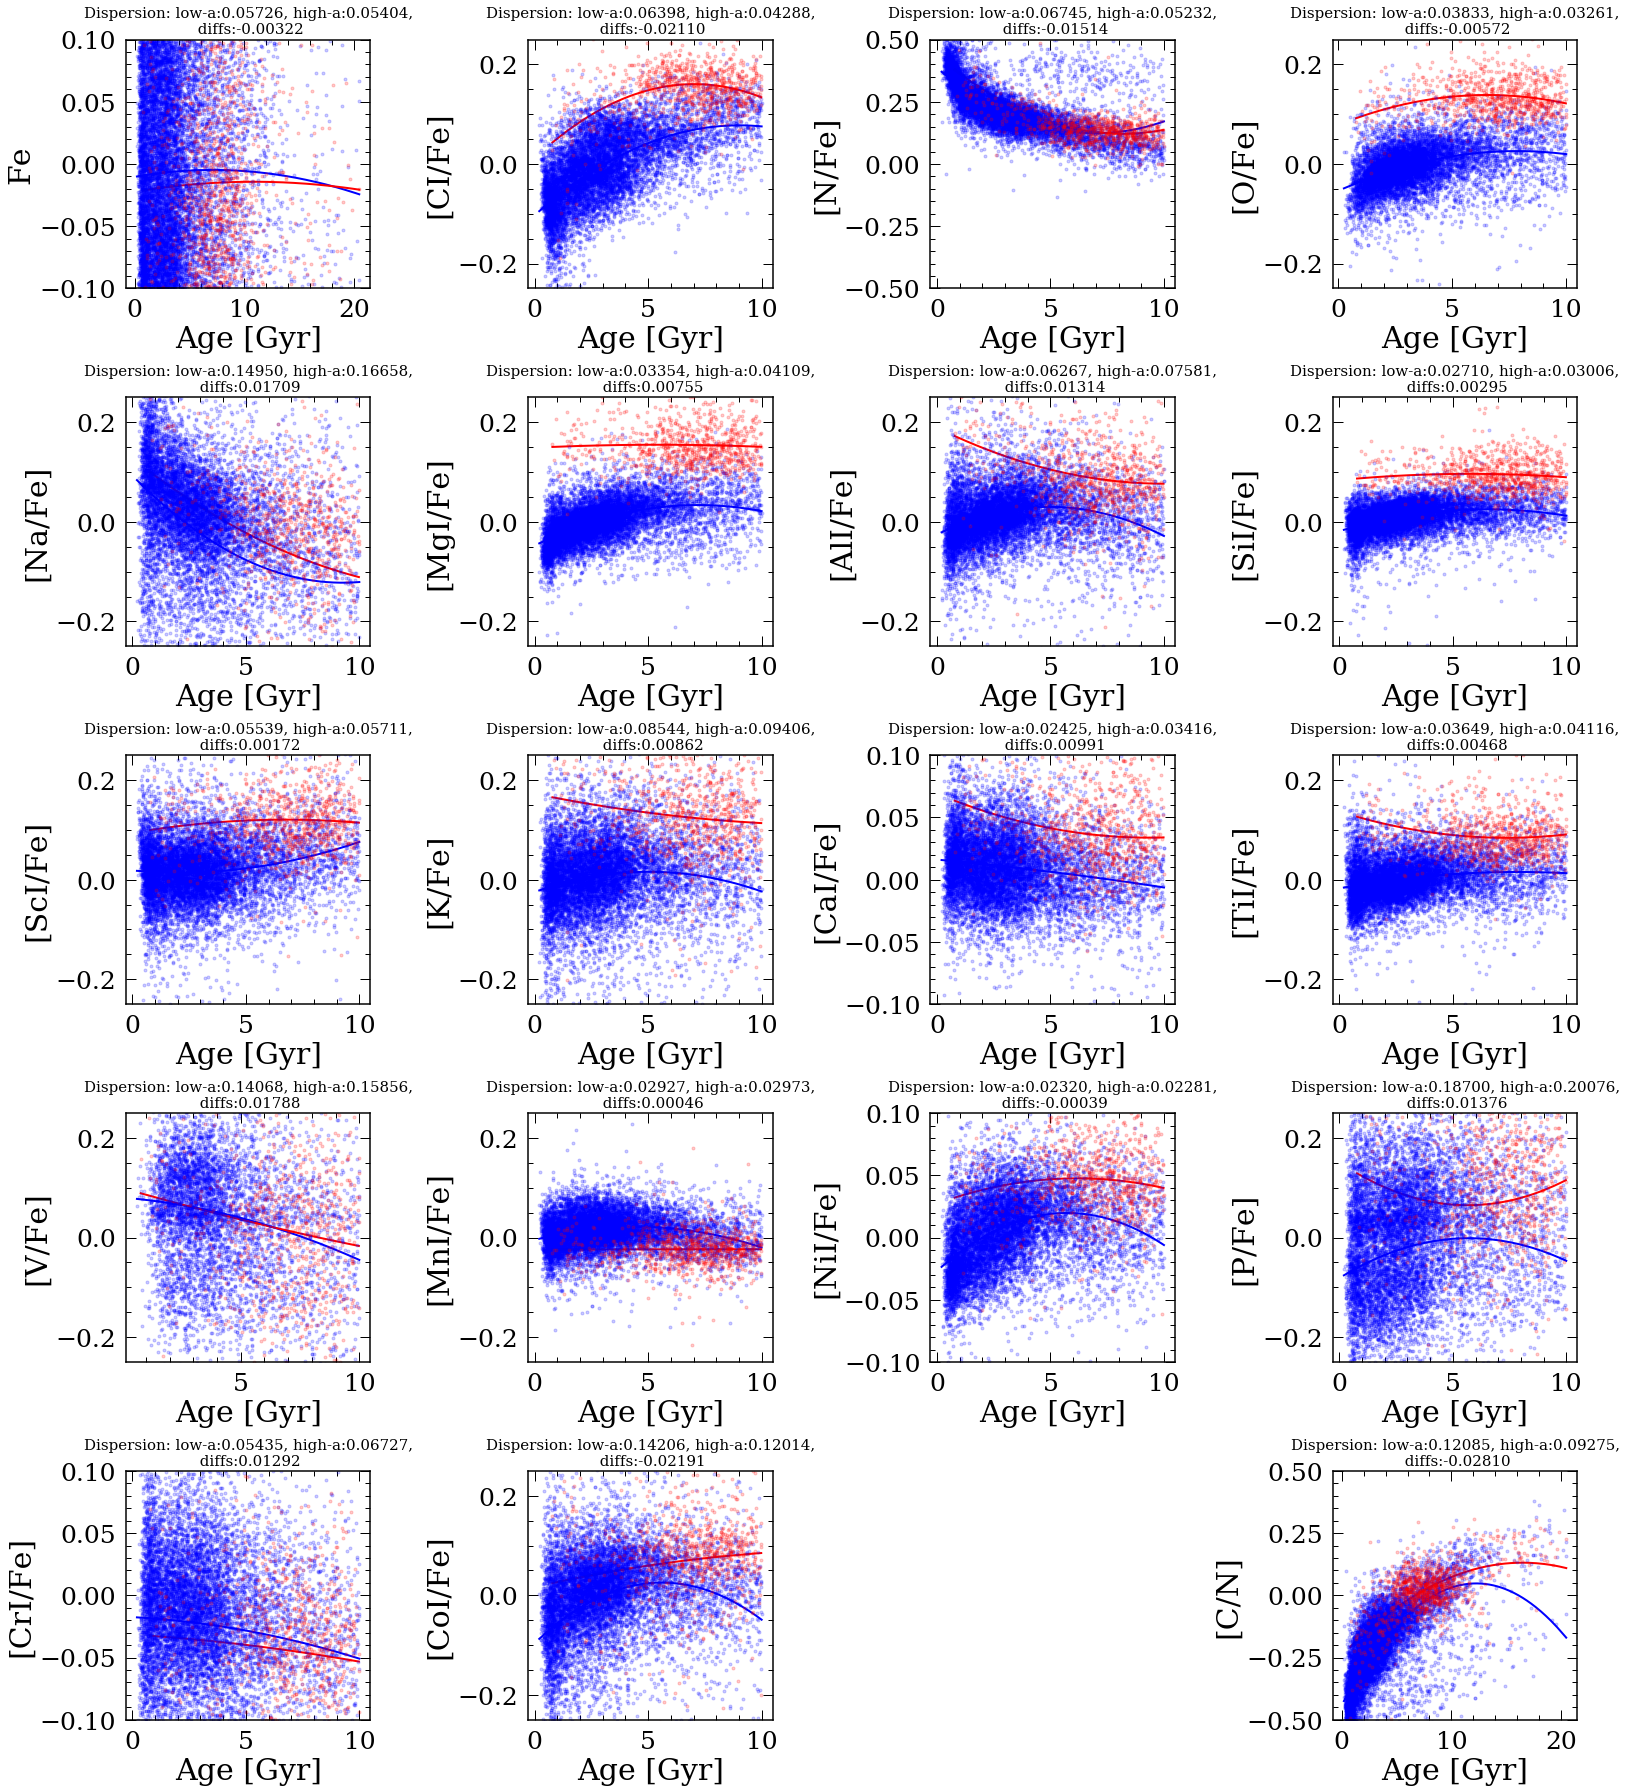

In [53]:
#hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance_cannon_rc')
hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance_cannon_rc','linear',2)



In [54]:
Abunname=[i.split('/')[0].split('[')[-1] for i in Abunname]
df_disp_rc=pd.DataFrame(np.array((Abunname,lo_dis,hi_dis)).T,columns=['Abund','la_dis_rc','ha_dis_rc'])

lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis=zip(*sorted(zip(lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis)))
#tot_lo_dis,lo_dis,Abunname,hi_dis,tot_hi_dis=zip(*sorted(zip(tot_lo_dis,lo_dis,Abunname,hi_dis,tot_hi_dis)))
df_disp_rc

,Abund,la_dis_rc,ha_dis_rc
0,CI,0.06398427098451705,0.04288254717056841
1,N,0.06745325318442821,0.05231596588665187
2,O,0.03832941193888162,0.032605408308121565
3,Na,0.1494971038689256,0.16658441141308503
4,MgI,0.033539930834014194,0.041087218020235246
5,AlI,0.06266813835038317,0.07580619432597911
6,SiI,0.027103017904266585,0.030056510277601554
7,ScI,0.05538744311747246,0.05711118131678029
8,K,0.08543623538111049,0.09405624112369433
9,CaI,0.024246460237801217,0.034155656830593246


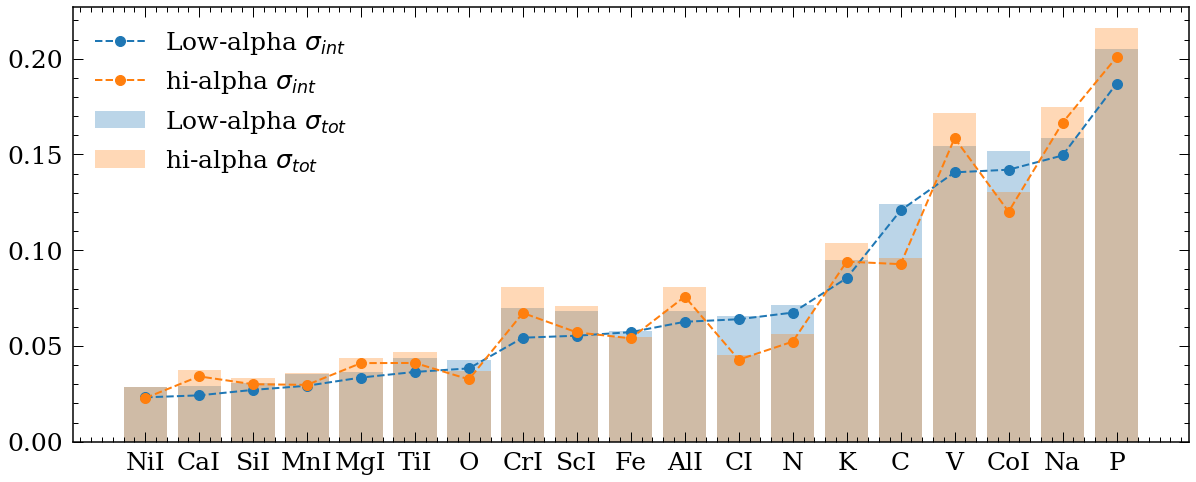

In [55]:
# normal
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_cannon_rc.png')

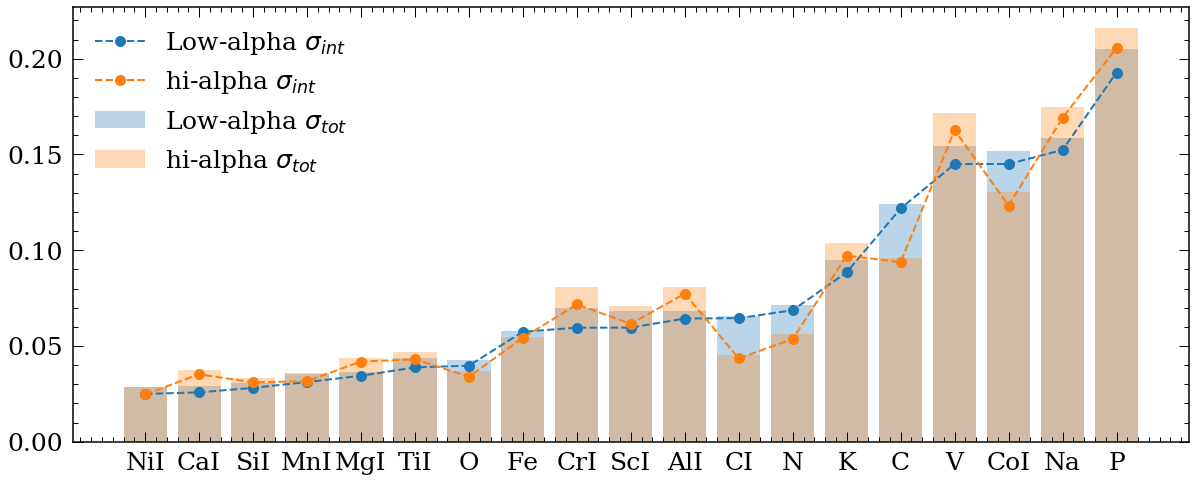

In [51]:
# 1.2
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_cannon_rc.png')